## Time-to-event models to examine recurrence-free survival and overall survival

kaplan maier, fit the model, multivariate analysis, features selection, shonfield residues

chi ha entrambe le terapie vanno tolti

se togli terapie, rischi che il modello vede pazienti gravi che guariscono.

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(1234)
from lifelines import KaplanMeierFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.preprocessing import StandardScaler
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold

df = pd.read_csv('../rotterdam.csv')

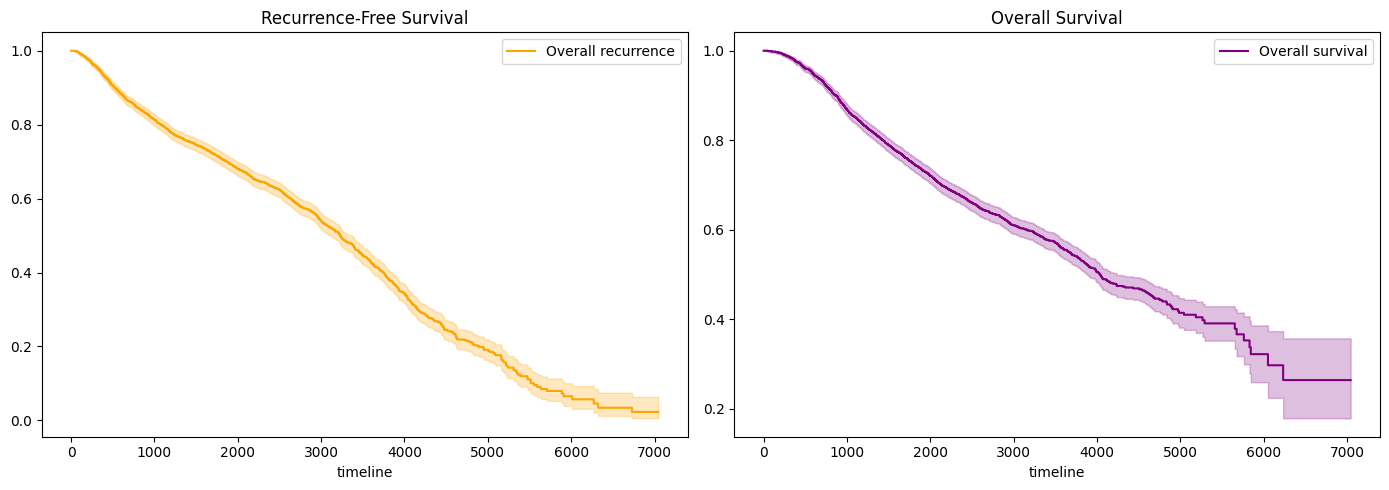

In [2]:
kmf = KaplanMeierFitter()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

kmf.fit(
    durations=df['rtime'],
    event_observed=df['recur'],
    label = 'Overall recurrence'
)
kmf.plot_survival_function(ax=ax1, color='orange')

kmf.fit(
    durations=df['dtime'],
    event_observed=df['death'],
    label = 'Overall survival'
)
kmf.plot_survival_function(ax=ax2, color='purple')

ax1.set_title('Recurrence-Free Survival')
ax2.set_title('Overall Survival')
plt.tight_layout()


In [3]:
needed = ['rtime', 'recur', 'dtime', 'death', 'grade', 'size', 'age', 'nodes', 'er', 'pgr', 'chemo', 'hormon']
df_clean = df[needed].copy()

# Overall survival (a death event, otherwise censored)
df_clean["os_time"]  = df_clean["dtime"]
df_clean["os_event"] = df_clean["death"].astype(int)

# Recurrence-free survival (a recurrence event, otherwise censored)
df_clean["rfs_time"]  = df_clean["rtime"]
df_clean["rfs_event"] = df_clean["recur"].astype(int)

In [4]:
# categorize ER and PGR into binary groups (0: <10, 1: >=10)
df_clean['er_cat'] = np.where(df_clean['er'] >= 10, 1, 0)
df_clean['pgr_cat'] = np.where(df_clean['pgr'] >= 10, 1, 0)

# Nodes as categorical groups: 0, 1-3, 4-9, 10+
node_bins = [-0.1, 0, 3, 9, np.inf]
node_labels = ['0', '1-3', '4-9', '10+']
df_clean['nodes_cat'] = pd.cut(df_clean['nodes'], bins=node_bins, labels=node_labels, right=True)

# ORDINAL encoding for nodes (0, 1, 2, 3 for the four categories)
nodes_ord_map = {'0': 0, '1-3': 1, '4-9': 2, '10+': 3}
df_clean['nodes_ord'] = df_clean['nodes_cat'].map(nodes_ord_map)

# grade: already ordinal (2 < 3)
# size: <=20, 20-50, >50 → map to 0, 1, 2
size_map = {'<=20': 0, '20-50': 1, '>50': 2}
df_clean['size_ord'] = df_clean['size'].map(size_map)

# age: binned into decades: (<40:0, 40-49:1, 50-59:2, 60-69:3, 70+:4)
age_bins = [0, 39, 49, 59, 69, np.inf]
age_labels = [0, 1, 2, 3, 4]
df_clean['age_bin'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, right=True).astype(int)

ordinal_features = ['grade', 'size_ord', 'age_bin', 'nodes_ord'] 
cat_features = ['er_cat', 'pgr_cat', 'chemo', 'hormon']

df0 = df_clean.copy()

In [5]:
covariates = ordinal_features + cat_features
base_cols = ["rfs_time", "rfs_event", "os_time", "os_event"]

model_df = df_clean[covariates + ["rtime", "recur", "dtime", "death"]].dropna().copy()

scaler = StandardScaler()
model_df[ordinal_features] = scaler.fit_transform(model_df[ordinal_features])

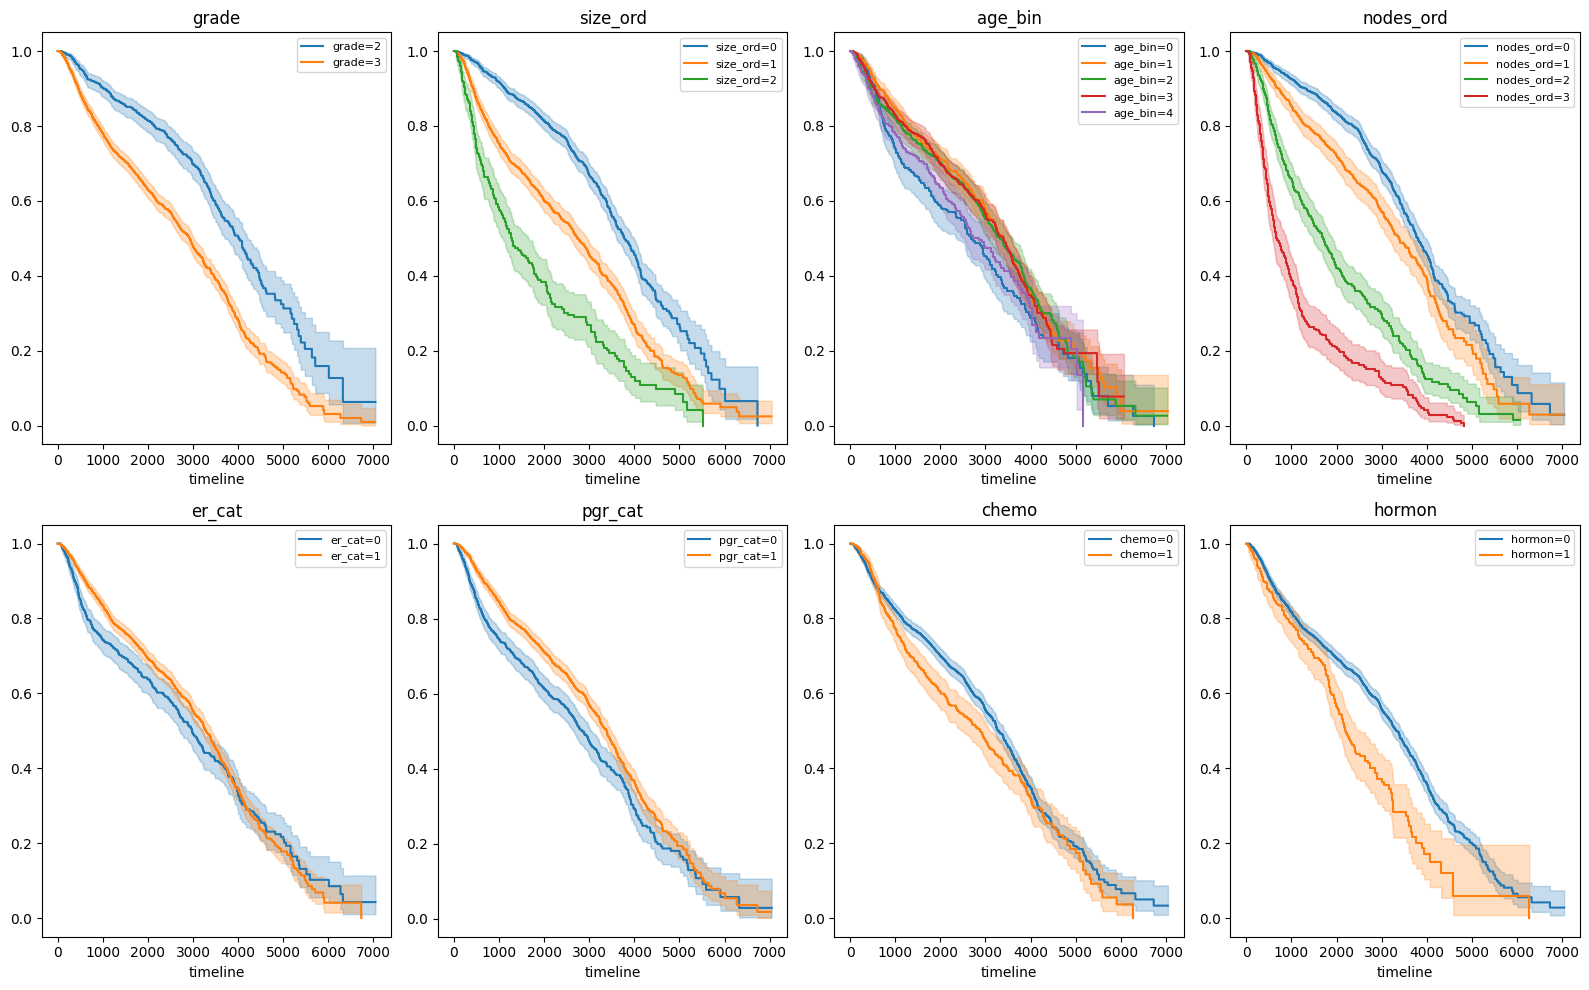

In [6]:
# Create a grid of subplots for all covariates
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, covariate in enumerate(covariates):
    covariate_values = np.sort(df_clean[covariate].unique())
    
    for value in covariate_values:
        mask = df_clean[covariate] == value
        kmf.fit(
            df_clean.loc[mask, 'rtime'],
            event_observed=df_clean.loc[mask, 'recur'],
            label=f'{covariate}={value}'
        )
        kmf.plot_survival_function(ax=axes[idx])
    
    axes[idx].set_title(f'{covariate}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()


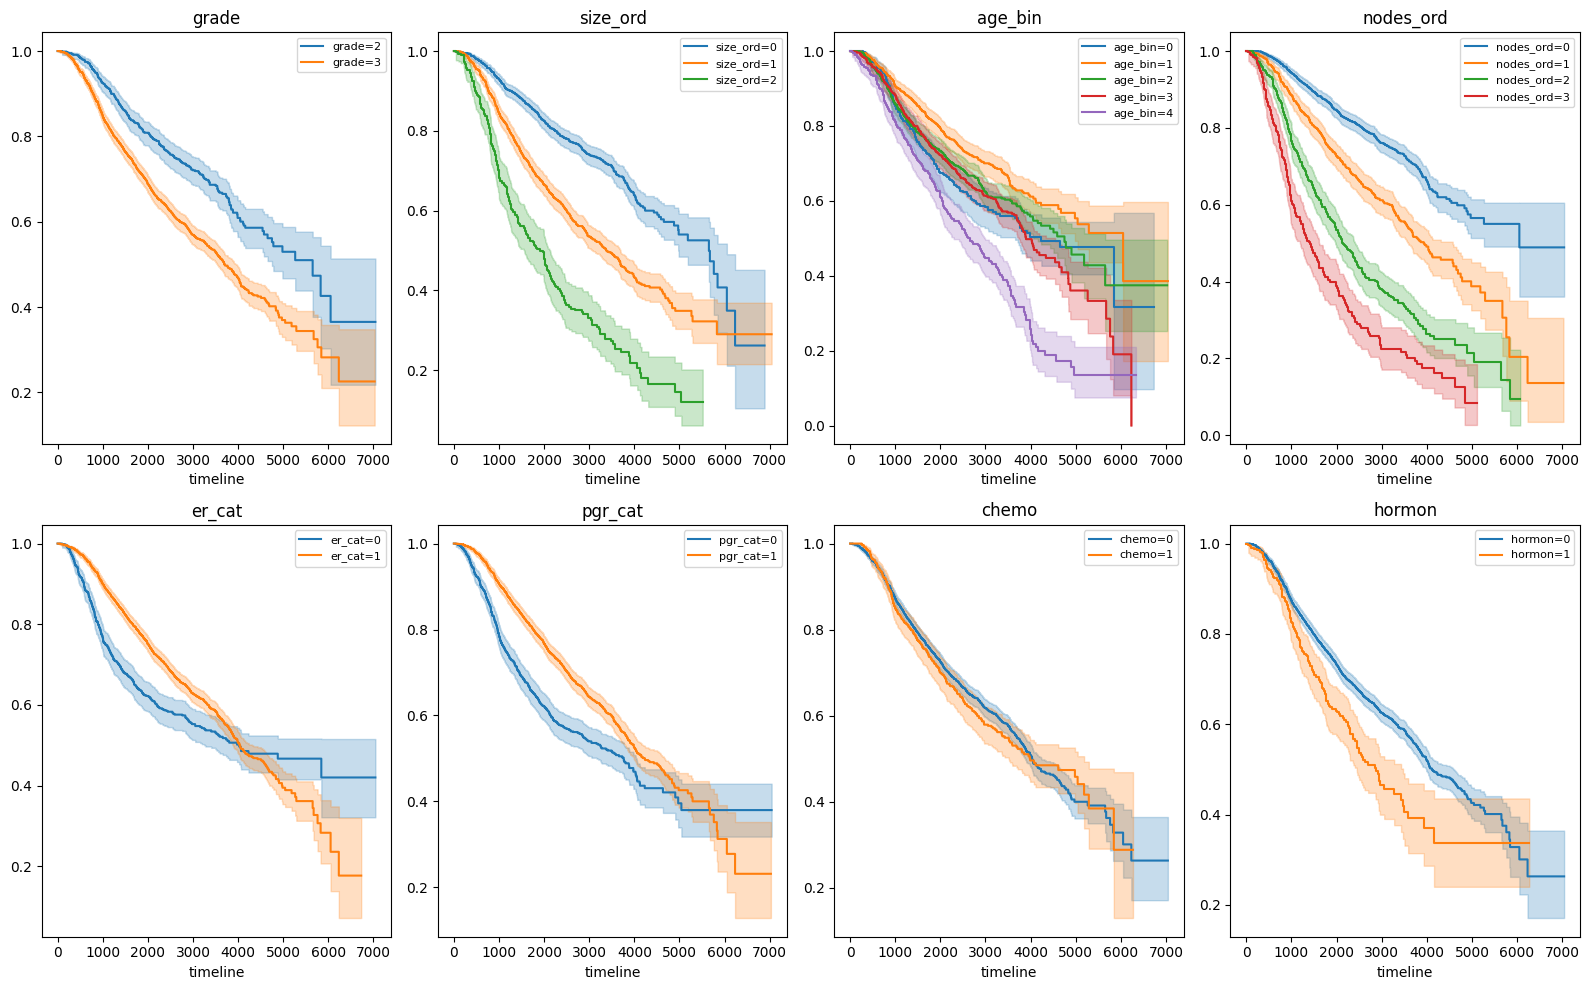

In [7]:
# Create a grid of subplots for all covariates
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, covariate in enumerate(covariates):
    covariate_values = np.sort(df_clean[covariate].unique())
    
    for value in covariate_values:
        mask = df_clean[covariate] == value
        kmf.fit(
            df_clean.loc[mask, 'dtime'],
            event_observed=df_clean.loc[mask, 'death'],
            label=f'{covariate}={value}'
        )
        kmf.plot_survival_function(ax=axes[idx])
    
    axes[idx].set_title(f'{covariate}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()


In [8]:
df[df.rtime > 7000]

,pid,year,age,hospital_id,meno,size,grade,nodes,pgr,er,hormon,chemo,rtime,recur,dtime,death
18,19,1979,51,5,0,20-50,3,1,14,0,0,0,7027,0,7027,0
758,767,1981,49,6,1,20-50,2,0,0,0,0,0,7043,0,7043,0


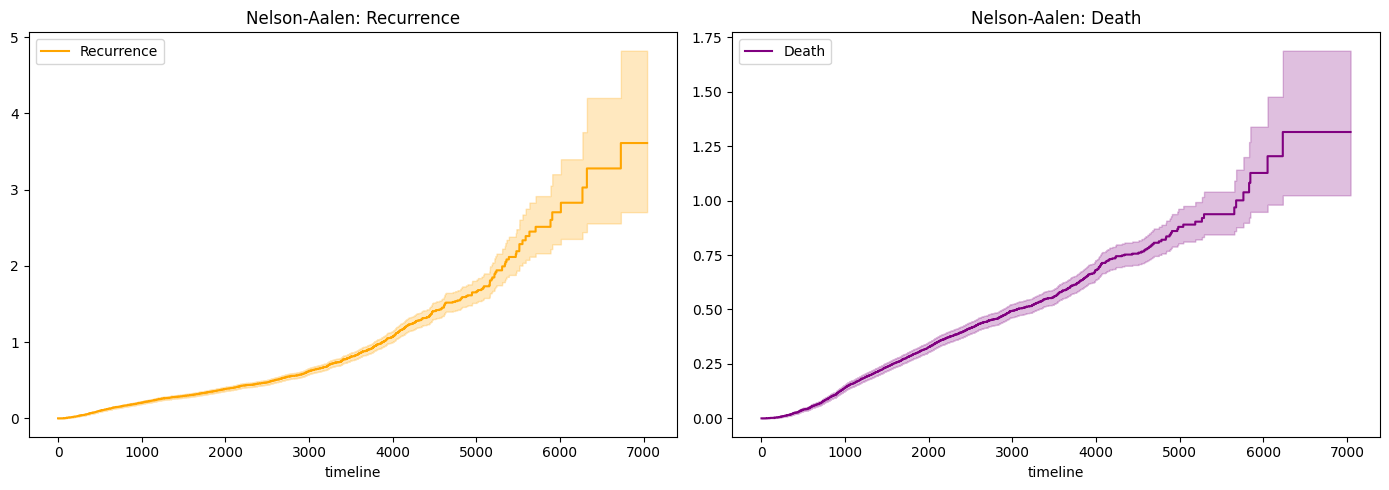

In [9]:
naf = NelsonAalenFitter()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

naf.fit(df['rtime'], event_observed=df['recur'], label='Recurrence')
naf.plot_cumulative_hazard(ax=ax1, color='orange')
ax1.set_title('Nelson-Aalen: Recurrence')

naf.fit(df['dtime'], event_observed=df['death'], label='Death')
naf.plot_cumulative_hazard(ax=ax2, color='purple')
ax2.set_title('Nelson-Aalen: Death')

plt.tight_layout()
plt.show()

In [10]:
#Log-Rank Tests on binary categorical variables to compare survival distributions
categorical_vars = ['er_cat', 'pgr_cat', 'hormon', 'chemo']
T = df_clean['rtime']
E = df_clean['recur']

for var in categorical_vars:
    group_1 = (df_clean[var] == 0)
    group_2 = (df_clean[var] == 1)
    # Perform log-rank test
    results = logrank_test(T[group_1], T[group_2], E[group_1], E[group_2])
    # Print the results
    print(f"\nLog-Rank Test for {var}:")
    results.print_summary()


Log-Rank Test for er_cat:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.77 0.05      4.26


Log-Rank Test for pgr_cat:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          22.99 <0.005     19.23


Log-Rank Test for hormon:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          30.73 <0.005     25.01


Log-Rank Test for chemo:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.18 <0.005      7.88

In [11]:
from lifelines.statistics import multivariate_logrank_test

#Log-Rank Test for survival distributions across ethnicity groups
results = multivariate_logrank_test(df_clean['rtime'], df_clean['size_ord'], df_clean['recur'])
results.print_summary()

results = multivariate_logrank_test(df_clean['rtime'], df_clean['nodes_ord'], df_clean['recur'])
results.print_summary()

results = multivariate_logrank_test(df_clean['rtime'], df_clean['grade'], df_clean['recur'])
results.print_summary()

results = multivariate_logrank_test(df_clean['rtime'], df_clean['age_bin'], df_clean['recur'])
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         271.85 <0.005    196.09

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         783.78 <0.005    560.90

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         103.76 <0.005     78.54

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          17.79 <0.005      9.53

In [12]:
# Prepare data for Cox model
df_clean_2 = df_clean[['age_bin', 'size_ord', 'grade', 'er_cat', 'pgr_cat', 'nodes_ord', 'hormon', 'chemo', 'rtime', 'recur', 'dtime', 'death']].copy()

# Scale ordinal features
scaler = StandardScaler()
ordinal_cols = ['age_bin', 'size_ord', 'grade', 'nodes_ord']
df_clean_2[ordinal_cols] = scaler.fit_transform(df_clean_2[ordinal_cols])

# Create dummy variables for categorical features
df_rec = pd.get_dummies(df_clean_2, columns=['hormon', 'chemo', 'pgr_cat', 'er_cat'], dtype=int, drop_first=True)
df_rec

,age_bin,size_ord,grade,nodes_ord,rtime,recur,dtime,death,hormon_1,chemo_1,pgr_cat_1,er_cat_1
0,1.55,-0.97,0.60,-0.87,1799,0,1799,0,0,0,1,1
1,1.55,0.55,0.60,-0.87,2828,0,2828,0,0,0,1,1
2,-0.83,-0.97,-1.66,-0.87,6012,1,6012,0,0,0,1,0
3,1.55,0.55,0.60,-0.87,2624,0,2624,0,0,0,0,1
4,1.55,-0.97,0.60,-0.87,4915,0,4915,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2977,1.55,0.55,0.60,0.13,1990,1,1990,1,0,0,1,1
2978,1.55,2.07,0.60,2.13,45,1,45,1,1,0,0,1
2979,1.55,0.55,0.60,1.13,582,0,582,1,0,0,1,1
2980,1.55,-0.97,0.60,-0.87,4972,0,4972,1,0,0,0,1


# Cox model

## First model with every variable

In [13]:
def fit_cox(df_in: pd.DataFrame, duration_col: str, event_col: str, label: str) -> CoxPHFitter:
    cph = CoxPHFitter()
    cph.fit(
        df_in.drop(columns=[c for c in ["rtime", "recur", "dtime", "death"] if c not in [duration_col, event_col]]),
        duration_col=duration_col,
        event_col=event_col,
        robust=True
    )

    print("\n" + "=" * 80)
    print(f"Cox model: {label}")
    print("=" * 80)
    # lifelines summary includes coef (log HR), exp(coef) (HR), CI, p-values
    print(cph.summary[["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]])

    return cph

# Recurrence-free survival (time to recurrence/censoring)
cph_rfs = fit_cox(df_clean_2, duration_col="rtime", event_col="recur", label="Recurrence-Free Survival (RFS)")

# Overall survival (time to death/censoring)
cph_os = fit_cox(df_clean_2, duration_col="dtime", event_col="death", label="Overall Survival (OS)")


Cox model: Recurrence-Free Survival (RFS)
           coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                                
age_bin   -0.15       0.86                 0.81                 0.92 0.00
size_ord   0.20       1.22                 1.15                 1.30 0.00
grade      0.21       1.23                 1.16                 1.31 0.00
er_cat     0.02       1.02                 0.86                 1.21 0.82
pgr_cat   -0.13       0.88                 0.75                 1.03 0.11
nodes_ord  0.60       1.82                 1.70                 1.95 0.00
hormon    -0.23       0.79                 0.66                 0.95 0.01
chemo     -0.48       0.62                 0.53                 0.73 0.00

Cox model: Overall Survival (OS)
           coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                                
age_bin    0.13       1.14         

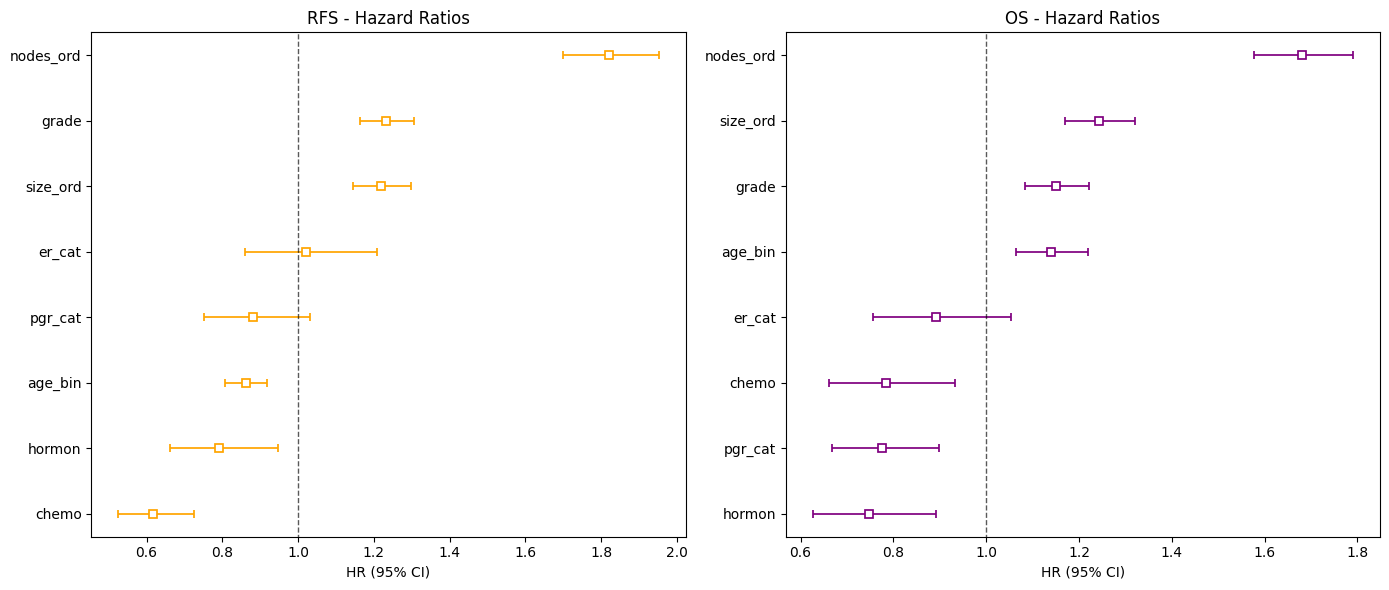

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

cph_rfs.plot(hazard_ratios=True, ax=ax1, c='orange')
ax1.set_title('RFS - Hazard Ratios')

cph_os.plot(hazard_ratios=True, ax=ax2, c='purple')
ax2.set_title('OS - Hazard Ratios')

plt.tight_layout()
plt.show()

### Cross-validation

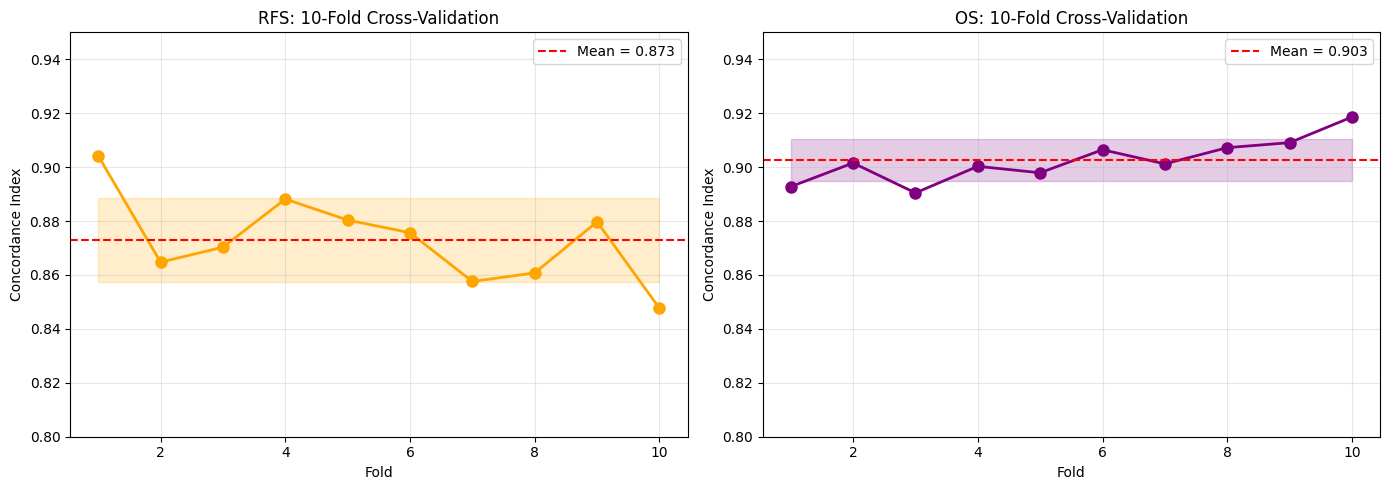


RFS C-index: mean=0.873, sd=0.016
OS C-index: mean=0.903, sd=0.008


In [15]:
# Perform cross-validation for RFS (recurrence)
scores = k_fold_cross_validation(
    cph_rfs, 
    model_df, 
    'rtime', 
    event_col='recur', 
    k=10, 
    scoring_method="concordance_index", 
    seed=1234
)

# Visualize cross-validation scores for RFS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='orange', linewidth=2, markersize=8)
ax1.axhline(y=np.mean(scores), color='red', linestyle='--', label=f'Mean = {np.mean(scores):.3f}')
ax1.fill_between(range(1, len(scores) + 1), 
                  np.mean(scores) - np.std(scores), 
                  np.mean(scores) + np.std(scores), 
                  alpha=0.2, color='orange')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Concordance Index')
ax1.set_title('RFS: 10-Fold Cross-Validation')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.8, 0.95])

# Perform cross-validation for OS (death)
scores_os = k_fold_cross_validation(
    cph_os, 
    model_df, 
    'dtime', 
    event_col='death', 
    k=10, 
    scoring_method="concordance_index", 
    seed=1234
)

ax2.plot(range(1, len(scores_os) + 1), scores_os, marker='o', linestyle='-', color='purple', linewidth=2, markersize=8)
ax2.axhline(y=np.mean(scores_os), color='red', linestyle='--', label=f'Mean = {np.mean(scores_os):.3f}')
ax2.fill_between(range(1, len(scores_os) + 1), 
                  np.mean(scores_os) - np.std(scores_os), 
                  np.mean(scores_os) + np.std(scores_os), 
                  alpha=0.2, color='purple')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Concordance Index')
ax2.set_title('OS: 10-Fold Cross-Validation')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.8, 0.95])

plt.tight_layout()
plt.show()

print(f"\nRFS C-index: mean={np.mean(scores):.3f}, sd={np.std(scores):.3f}")
print(f"OS C-index: mean={np.mean(scores_os):.3f}, sd={np.std(scores_os):.3f}")

## Forward and Backward selection

In [16]:
# Selected variables
selected_columns_rfs = ['age_bin', 'size_ord', 'grade', 'er_cat', 'pgr_cat', 'nodes_ord', 'hormon', 'chemo', 'rtime', 'recur']
selected_columns_os = ['age_bin', 'size_ord', 'grade', 'er_cat', 'pgr_cat', 'nodes_ord', 'hormon', 'chemo', 'dtime', 'death']

df_clean_rfs = df_clean[selected_columns_rfs].copy()
df_clean_os = df_clean[selected_columns_os].copy()

In [ ]:
%pip install -q scikit-survival

from sklearn.model_selection import KFold
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis

cv = KFold(n_splits=5, shuffle=True, random_state=42)

time_col_rfs = 'rtime'
event_col_rfs = 'recur'
time_col_os = 'dtime'
event_col_os = 'death'

covariates_rfs = [c for c in df_clean_rfs.columns if c not in [time_col_rfs, event_col_rfs]]
covariates_os = [c for c in df_clean_os.columns if c not in [time_col_os, event_col_os]]

X_rfs = df_clean_rfs[covariates_rfs]
y_rfs = Surv.from_dataframe(event_col_rfs, time_col_rfs, df_clean_rfs)

X_os = df_clean_os[covariates_os]
y_os = Surv.from_dataframe(event_col_os, time_col_os, df_clean_os)

cox_rfs = CoxPHSurvivalAnalysis()
cox_rfs.fit(X_rfs, y_rfs)

cox_os = CoxPHSurvivalAnalysis()
cox_os.fit(X_os, y_os)

SyntaxError: invalid syntax (2892484399.py, line 4)

### Forward selection

In [ ]:
sfs_forward_rfs = SequentialFeatureSelector(
    estimator=cox_rfs,
    n_features_to_select="auto",
    direction="forward",
    cv=cv,
)

sfs_forward_rfs.fit(X_rfs, y_rfs)

selected_forward_rfs = X_rfs.columns[sfs_forward_rfs.get_support()].tolist()
print("RFS - Forward selection:", selected_forward_rfs)

sfs_forward_os = SequentialFeatureSelector(
    estimator=cox_os,
    n_features_to_select="auto",
    direction="forward",
    cv=cv,
)

sfs_forward_os.fit(X_os, y_os)

selected_forward_os = X_os.columns[sfs_forward_os.get_support()].tolist()
print("OS - Forward selection:", selected_forward_os)

AttributeError: CoxPHFitter has no attribute '__sklearn_tags__'

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores_forward_rfs = cross_val_score(
    CoxPHFitter(),
    X_rfs[selected_forward_rfs],
    y_rfs,
    cv=cv,
)
print("RFS - Forward selection - CV c-index: ",
      f"{cv_scores_forward_rfs.mean():.4f} ± {cv_scores_forward_rfs.std():.4f}")

cv_scores_forward_os = cross_val_score(
    CoxPHFitter(),
    X_os[selected_forward_os],
    y_os,
    cv=cv,
)
print("OS - Forward selection - CV c-index: ",
      f"{cv_scores_forward_os.mean():.4f} ± {cv_scores_forward_os.std():.4f}")

Iteration 1: Evaluating 8 candidate features...
  Added: nodes_ord (C-index: 0.6843)
Iteration 2: Evaluating 7 candidate features...
  Added: size_ord (C-index: 0.7044)
Iteration 3: Evaluating 6 candidate features...
  Added: grade (C-index: 0.7158)
Iteration 4: Evaluating 5 candidate features...
  Added: pgr_cat (C-index: 0.7206)
Iteration 5: Evaluating 4 candidate features...
  Added: hormon (C-index: 0.7228)
Iteration 6: Evaluating 3 candidate features...
  Added: chemo (C-index: 0.7232)
Iteration 7: Evaluating 2 candidate features...
  Added: age_bin (C-index: 0.7277)
Iteration 8: Evaluating 1 candidate features...
  Added: er_cat (C-index: 0.7294)


### Backward selection

In [ ]:
sfs_backward_rfs = SequentialFeatureSelector(
    estimator=cox_rfs,
    n_features_to_select="auto",
    direction="backward",
    cv=cv,
)

sfs_backward_rfs.fit(X_rfs, y_rfs)

selected_backward_rfs = X_rfs.columns[sfs_backward_rfs.get_support()].tolist()
print("Backward selection for the Recurrence-free survival:", selected_backward_rfs)

sfs_backward_os = SequentialFeatureSelector(
    estimator=cox_os,
    n_features_to_select="auto",
    direction="backward",
    cv=cv,
)

sfs_backward_os.fit(X_os, y_os)

selected_backward_os = X_os.columns[sfs_backward_os.get_support()].tolist()
print("Backward selection for the Overall survival:", selected_backward_os)

In [ ]:
cv_scores_backward = cross_val_score(
    CoxPHFitter(),
    X_rfs[selected_backward_rfs],
    y_rfs,
    cv=cv,
)
print("RFS - Backward selection - CV c-index: ",
      f"{cv_scores_backward.mean():.4f} ± {cv_scores_backward.std():.4f}")

cv_scores_backward_os = cross_val_score(
    CoxPHFitter(),
    X_os[selected_backward_os],
    y_os,
    cv=cv,
)
print("OS - Backward selection - CV c-index: ",
        f"{cv_scores_backward_os.mean():.4f} ± {cv_scores_backward_os.std():.4f}")

Iteration 1: Testing removal of features from 8 remaining features...
  → Removed feature(s). Best C-index: 0.7017 with 7 features remaining.
Iteration 2: Testing removal of features from 7 remaining features...
  → Removed feature(s). Best C-index: 0.7008 with 6 features remaining.
Iteration 3: Testing removal of features from 6 remaining features...
  → Removed feature(s). Best C-index: 0.6502 with 5 features remaining.
Iteration 4: Testing removal of features from 5 remaining features...
  → Removed feature(s). Best C-index: 0.6489 with 4 features remaining.
Iteration 5: Testing removal of features from 4 remaining features...
  → Removed feature(s). Best C-index: 0.6440 with 3 features remaining.
Iteration 6: Testing removal of features from 3 remaining features...
  → Removed feature(s). Best C-index: 0.6346 with 2 features remaining.
Iteration 7: Testing removal of features from 2 remaining features...
  → Removed feature(s). Best C-index: 0.5494 with 1 features remaining.


### Best subset

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

efs = EFS(
    estimator=cox,
    min_features=2,
    max_features=4, # to speed up, otherwise len(covariates)
    scoring=lambda est, X_sub, y_sub: est.score(X_sub, y_sub),
    cv=cv,
    print_progress=True,
)

efs = efs.fit(X, y)

best_idx = list(efs.best_idx_) # indexes of the selected features
best_subset = [covariates[i] for i in best_idx]

print("Best subset:", best_subset)
print("Best CV c-index:", efs.best_score_)

---

In [ ]:
recur = (df['recur'] == 1)

T = df['rtime']
E = df['recur']

results = logrank_test(T[recur], T[~recur], E[recur], E[~recur])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1787.39 <0.005       inf

In [ ]:
# Prepare data for Cox model
df_clean_2 = df_clean[['age_bin', 'size_ord', 'grade', 'er_cat', 'pgr_cat', 'nodes_ord', 'hormon', 'chemo', 'rtime', 'recur', 'dtime', 'death']].copy()

# Scale ordinal features
scaler = StandardScaler()
ordinal_cols = ['age_bin', 'size_ord', 'grade', 'nodes_ord']
df_clean_2[ordinal_cols] = scaler.fit_transform(df_clean_2[ordinal_cols])

# Create dummy variables for categorical features
df_rec = pd.get_dummies(df_clean_2, columns=['hormon', 'chemo', 'pgr_cat', 'er_cat'], dtype=int, drop_first=True)
df_rec

,age_bin,size_ord,grade,nodes_ord,rtime,recur,dtime,death,hormon_1,chemo_1,pgr_cat_1,er_cat_1
0,1.55,-0.97,0.60,-0.87,1799,0,1799,0,0,0,1,1
1,1.55,0.55,0.60,-0.87,2828,0,2828,0,0,0,1,1
2,-0.83,-0.97,-1.66,-0.87,6012,1,6012,0,0,0,1,0
3,1.55,0.55,0.60,-0.87,2624,0,2624,0,0,0,0,1
4,1.55,-0.97,0.60,-0.87,4915,0,4915,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2977,1.55,0.55,0.60,0.13,1990,1,1990,1,0,0,1,1
2978,1.55,2.07,0.60,2.13,45,1,45,1,1,0,0,1
2979,1.55,0.55,0.60,1.13,582,0,582,1,0,0,1,1
2980,1.55,-0.97,0.60,-0.87,4972,0,4972,1,0,0,0,1


In [ ]:
def fit_cox(df_in: pd.DataFrame, duration_col: str, event_col: str, label: str, penalizer: float = 0.01) -> CoxPHFitter:
    """
    Fits a Cox model and prints a compact, interpretable summary.
    penalizer > 0 stabilizes the fit when predictors are correlated.
    """
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(
        df_in.drop(columns=[c for c in ["rtime", "recur", "dtime", "death"] if c not in [duration_col, event_col]]),
        duration_col=duration_col,
        event_col=event_col,
        robust=True
    )

    print("\n" + "=" * 80)
    print(f"Cox model: {label}")
    print("=" * 80)
    # lifelines summary includes coef (log HR), exp(coef) (HR), CI, p-values
    print(cph.summary[["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]])

    return cph

# Recurrence-free survival (time to recurrence/censoring)
cph_rfs = fit_cox(df_clean_2, duration_col="rtime", event_col="recur", label="Recurrence-Free Survival (RFS)")

# Overall survival (time to death/censoring)
cph_os = fit_cox(df_clean_2, duration_col="dtime", event_col="death", label="Overall Survival (OS)")


Cox model: Recurrence-Free Survival (RFS)
           coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                                
age_bin   -0.14       0.87                 0.82                 0.93 0.00
size_ord   0.20       1.22                 1.15                 1.30 0.00
grade      0.20       1.23                 1.16                 1.30 0.00
er_cat     0.02       1.02                 0.86                 1.20 0.83
pgr_cat   -0.13       0.88                 0.76                 1.02 0.10
nodes_ord  0.58       1.79                 1.68                 1.92 0.00
hormon    -0.22       0.80                 0.68                 0.96 0.01
chemo     -0.45       0.64                 0.54                 0.74 0.00

Cox model: Overall Survival (OS)
           coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                                
age_bin    0.13       1.14         

In [ ]:
# Print Hazard Ratios for RFS Model
print("\n" + "=" * 80)
print("HAZARD RATIOS - Recurrence-Free Survival (RFS)")
print("=" * 80)
rfs_hr = cph_rfs.summary[["exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]].copy()
rfs_hr.columns = ["HR", "HR_lower_95%", "HR_upper_95%", "p-value"]
print(rfs_hr)

print("\n" + "=" * 80)
print("HAZARD RATIOS - Overall Survival (OS)")
print("=" * 80)
os_hr = cph_os.summary[["exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]].copy()
os_hr.columns = ["HR", "HR_lower_95%", "HR_upper_95%", "p-value"]
print(os_hr)


HAZARD RATIOS - Recurrence-Free Survival (RFS)
            HR  HR_lower_95%  HR_upper_95%  p-value
covariate                                          
age_bin   0.87          0.82          0.93     0.00
size_ord  1.22          1.15          1.30     0.00
grade     1.23          1.16          1.30     0.00
er_cat    1.02          0.86          1.20     0.83
pgr_cat   0.88          0.76          1.02     0.10
nodes_ord 1.79          1.68          1.92     0.00
hormon    0.80          0.68          0.96     0.01
chemo     0.64          0.54          0.74     0.00

HAZARD RATIOS - Overall Survival (OS)
            HR  HR_lower_95%  HR_upper_95%  p-value
covariate                                          
age_bin   1.14          1.07          1.21     0.00
size_ord  1.24          1.17          1.32     0.00
grade     1.15          1.08          1.22     0.00
er_cat    0.89          0.76          1.05     0.16
pgr_cat   0.78          0.68          0.90     0.00
nodes_ord 1.66          1.56 

In [ ]:
def fit_cox(df_in: pd.DataFrame, duration_col: str, event_col: str, label: str, penalizer: float = 0.01) -> CoxPHFitter:
    """
    Fits a Cox model and prints a compact, interpretable summary.
    penalizer > 0 stabilizes the fit when predictors are correlated.
    """
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(
        df_in.drop(columns=[c for c in ["rtime", "recur", "dtime", "death"] if c not in [duration_col, event_col]]),
        duration_col=duration_col,
        event_col=event_col,
        robust=True
    )

    print("\n" + "=" * 80)
    print(f"Cox model: {label}")
    print("=" * 80)
    # lifelines summary includes coef (log HR), exp(coef) (HR), CI, p-values
    print(cph.summary[["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]])

    return cph

df_clean_2_rfs = df_clean_2[['age_bin', 'size_ord', 'grade', 'nodes_ord', 'hormon', 'chemo', 'rtime', 'recur', 'dtime', 'death']].copy()


# Recurrence-free survival (time to recurrence/censoring)
cph_rfs = fit_cox(df_clean_2_rfs, duration_col="rtime", event_col="recur", label="Recurrence-Free Survival (RFS)")

# Overall survival (time to death/censoring)
cph_os = fit_cox(df_clean_2, duration_col="dtime", event_col="death", label="Overall Survival (OS)")


Cox model: Recurrence-Free Survival (RFS)
           coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                                
age_bin   -0.14       0.87                 0.82                 0.92 0.00
size_ord   0.20       1.22                 1.15                 1.30 0.00
grade      0.21       1.24                 1.17                 1.31 0.00
nodes_ord  0.59       1.80                 1.68                 1.92 0.00
hormon    -0.21       0.81                 0.68                 0.96 0.02
chemo     -0.46       0.63                 0.54                 0.74 0.00

Cox model: Overall Survival (OS)
           coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                                
age_bin    0.13       1.14                 1.07                 1.21 0.00
size_ord   0.22       1.24                 1.17                 1.32 0.00
grade      0.14       1.15         

In [ ]:
cph_rfs.check_assumptions(df_clean_2[covariates + ["rtime", "recur"]], p_value_threshold = 0.05)
cph_os.check_assumptions(df_clean_2[covariates + ["dtime", "death"]], p_value_threshold = 0.05)

ValueError: shapes (2982,8) and (6,) not aligned: 8 (dim 1) != 6 (dim 0)

In [ ]:
def cv_cindex(df_in: pd.DataFrame, duration_col: str, event_col: str, label: str, penalizer: float = 0.01, k: int = 5):
    cph = CoxPHFitter(penalizer=penalizer)
    scores = k_fold_cross_validation(
        cph,
        df_in.drop(columns=[c for c in ["rtime", "recur", "dtime", "death"] if c not in [duration_col, event_col]]),
        duration_col=duration_col,
        event_col=event_col,
        k=k,
        scoring_method="concordance_index",
    )
    print(f"\n{label} | {k}-fold C-index: mean={np.mean(scores):.3f}, sd={np.std(scores):.3f}")
    return scores

cv_cindex(model_df, "rtime", "recur", "RFS")
cv_cindex(model_df, "dtime", "death", "OS")


RFS | 5-fold C-index: mean=0.726, sd=0.031

OS | 5-fold C-index: mean=0.703, sd=0.014


[np.float64(0.6982887435875472),
 np.float64(0.6995480924745505),
 np.float64(0.7288053473609271),
 np.float64(0.7011173184357542),
 np.float64(0.6849274840616504)]

In [ ]:
# This can show warnings if a covariate's effect changes over time.
# If something violates PH, you can consider: stratification, time-interactions, or re-coding.
print("\nPH check: RFS model")
cph_rfs.check_assumptions(model_df[covariates + ["rtime", "recur"]], p_value_threshold=0.05, show_plots=False)

print("\nPH check: OS model")
cph_os.check_assumptions(model_df[covariates + ["dtime", "death"]], p_value_threshold=0.05, show_plots=False)


PH check: RFS model
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2982 total observations, 1509 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic      p  -log2(p)
age_bin   km              0.38   0.54      0.89
          rank            0.83   0.36      1.46
chemo     km              4.97   0.03      5.28
          rank            3.86   0.05      4.34
er_cat    km            757.59 <0.005    551.59
          rank          887.41 <0.005    645.35
grade     km              1.28   0.26      1.95
          rank            0.63   0.43      1.22
hormon    km              1.94   0.16      2.61
          rank            1.78   0.18      2.46
nodes_ord km             53.23 <0.005     41.62
          rank           59.97 <0.005     46.56
pgr_cat   km            283.30 <0.005    208.76
          rank          324.89 <0.005    238.86
size_ord  km             77.35 <0.005     59.28
          rank           88.85 <0.005     67.67



1. Variable 'size_ord' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['size_ord', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'er_cat' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['er_cat', ...]` in the call
in `.fit`. See documentation in link [E] below.

3. Variable 'pgr_cat' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['pgr_cat', ...]` in the call
in `.fit`. See documentation in link [E] below.

4. Variable 'nodes_ord' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 4), you can include `strata=['nodes_ord', ...]` in the
call in `.fit`. See documentation in link [E] below.

5. Variable 'chemo' failed the non-proportional test: p-value is 0.0258.

   Advice: with 

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2982 total observations, 1710 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic      p  -log2(p)
age_bin   km              0.33   0.56      0.83
          rank            0.27   0.60      0.73
chemo     km             10.04 <0.005      9.35
          rank            9.04 <0.005      8.57
er_cat    km            419.55 <0.005    307.33
          rank          445.16 <0.005    325.84
grade     km             16.25 <0.005     14.14
          rank           12.44 <0.005     11.22
hormon    km              1.79   0.18      2.47
          rank            1.27   0.26      1.95
nodes_ord km             42.65 <0.005     33.83
          rank           43.20 <0.005     34.23
pgr_cat   km            350.61 <0.005    257.47
          rank          362.47 <0.005    266.05
size_ord  km             33.00 <0.005     26.70
          rank           31.63 <0.005     25.67



1. Variable 'size_ord' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['size_ord', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'grade' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['grade', ...]` in the call
in `.fit`. See documentation in link [E] below.

3. Variable 'er_cat' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['er_cat', ...]` in the call
in `.fit`. See documentation in link [E] below.

4. Variable 'pgr_cat' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['pgr_cat', ...]` in the call
in `.fit`. See documentation in link [E] below.

5. Variable 'nodes_ord' failed the non-proportional test: p-value is <5e-05.

   Advice: with so f

[]

In [ ]:
# Use the same columns the RFS Cox model was fitted on to compute residuals
rfs_cols = list(cph_rfs.params_.index) + ["rtime", "recur"]
mr_rfs = cph_rfs.compute_residuals(df_clean_2[rfs_cols], 'martingale')
mr_rfs.head()

,rtime,recur,martingale
401,36.00,False,0.00
1640,38.00,True,1.00
2978,45.00,True,1.00
2748,49.00,True,1.00
2035,50.00,False,-0.00


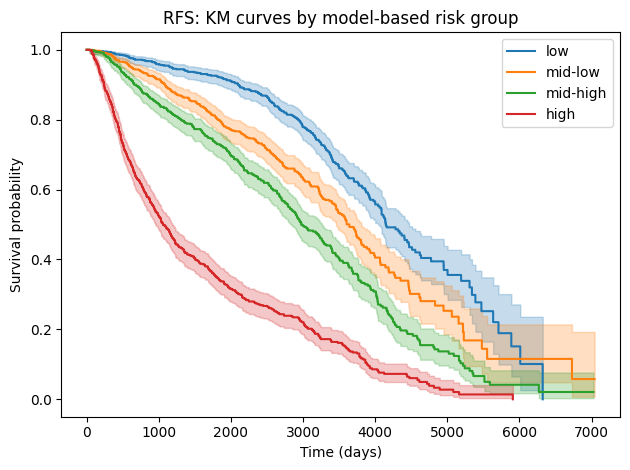

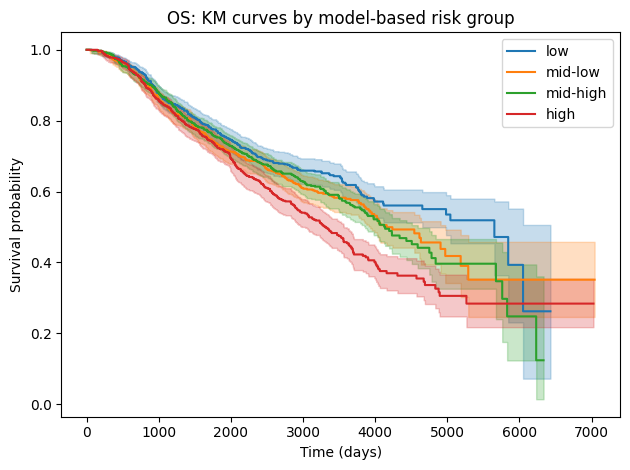

In [ ]:
def plot_risk_groups_km(cph: CoxPHFitter, df_in: pd.DataFrame, duration_col: str, event_col: str, title: str):
    # Predict partial hazard (relative risk)
    risk = cph.predict_partial_hazard(df_in[covariates]).rename("risk")

    tmp = df_in[[duration_col, event_col]].copy()
    tmp["risk"] = risk.values

    # 4 groups using quantiles (simple + stable)
    tmp["risk_group"] = pd.qcut(tmp["risk"], q=4, labels=["low", "mid-low", "mid-high", "high"])

    kmf = KaplanMeierFitter()

    plt.figure()
    for g in ["low", "mid-low", "mid-high", "high"]:
        m = tmp["risk_group"] == g
        kmf.fit(tmp.loc[m, duration_col], event_observed=tmp.loc[m, event_col], label=g)
        kmf.plot_survival_function()

    plt.title(title)
    plt.xlabel("Time (days)")
    plt.ylabel("Survival probability")
    plt.tight_layout()
    plt.show()

plot_risk_groups_km(cph_rfs, model_df, "rtime", "recur", "RFS: KM curves by model-based risk group")
plot_risk_groups_km(cph_os, model_df, "dtime", "death", "OS: KM curves by model-based risk group")

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess as lowess

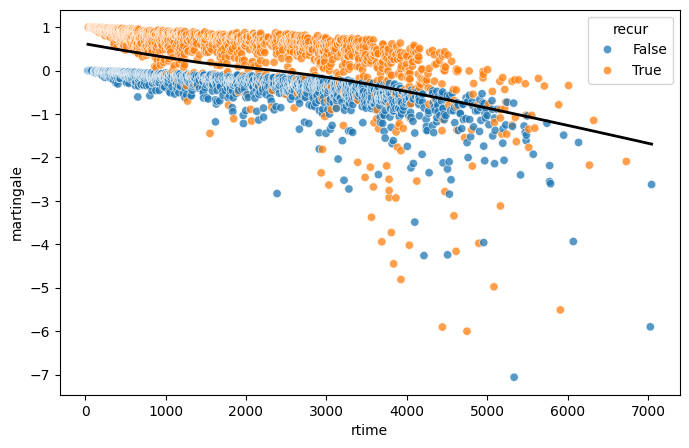

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=mr_rfs,
    x='rtime', y='martingale', hue='recur',
    alpha=0.75,
    ax=ax
)
y_lowess = lowess(mr_rfs.martingale.values, mr_rfs.rtime.values, return_sorted=False)
ax.plot(mr_rfs.rtime.values, y_lowess, color="k", alpha=1.0, linewidth=2)
plt.show()

In [ ]:
# Deviance residuals using the same columns the RFS model was fitted on
rfs_cols = list(cph_rfs.params_.index) + ["rtime", "recur"]
dr = cph_rfs.compute_residuals(df_clean_2[rfs_cols], "deviance")
dr.head()

,rtime,recur,deviance
401,36.00,False,-0.00
1640,38.00,True,3.77
2978,45.00,True,3.17
2748,49.00,True,3.71
2035,50.00,False,-0.03


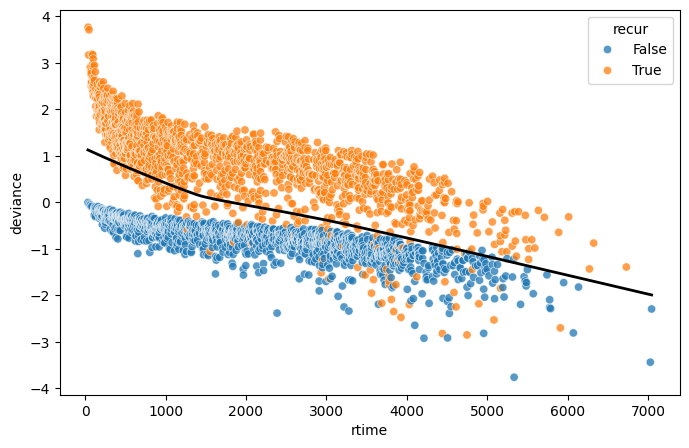

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=dr,
    x='rtime', y='deviance', hue='recur',
    alpha=0.75,
    ax=ax
)
y_lowess = lowess(dr.deviance.values, dr.rtime.values, return_sorted=False)
ax.plot(dr.rtime.values, y_lowess, color="k", alpha=1.0, linewidth=2, zorder=2)
plt.show()

## Address proportional hazards violations
We fit stratified Cox models using the most problematic covariates as strata, then compare fit statistics and discrimination.

In [ ]:
# Build a dataset with original (unscaled) categorical strata variables
df_strata = df_clean[['rtime', 'recur', 'dtime', 'death',
                      'age_bin', 'grade', 'size_ord', 'nodes_ord',
                      'er_cat', 'pgr_cat', 'chemo', 'hormon']].copy()

def fit_stratified_cox(df_in: pd.DataFrame, duration_col: str, event_col: str, strata_vars: list, label: str):
    # Keep only covariates + the specified duration/event to avoid leakage
    drop_cols = [c for c in ["rtime", "recur", "dtime", "death"] if c not in [duration_col, event_col]]
    df_fit = df_in.drop(columns=drop_cols)
    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(
        df_fit,
        duration_col=duration_col,
        event_col=event_col,
        strata=strata_vars,
        robust=True,
    )
    print("\n" + "=" * 80)
    print(f"Stratified Cox model: {label}")
    print("Strata:", strata_vars)
    print("=" * 80)
    print(cph.summary[["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]])
    print(f"Concordance index: {cph.concordance_index_:.3f}")
    return cph

# RFS: stratify by variables with strongest PH violations
rfs_strata = ['size_ord', 'nodes_ord', 'er_cat', 'pgr_cat', 'chemo']
cph_rfs_strat = fit_stratified_cox(
    df_strata, duration_col="rtime", event_col="recur", strata_vars=rfs_strata,
    label="RFS (stratified)"
 )

# OS: include grade among strata due to PH violation
os_strata = ['size_ord', 'nodes_ord', 'er_cat', 'pgr_cat', 'chemo', 'grade']
cph_os_strat = fit_stratified_cox(
    df_strata, duration_col="dtime", event_col="death", strata_vars=os_strata,
    label="OS (stratified)"
 )


Stratified Cox model: RFS (stratified)
Strata: ['size_ord', 'nodes_ord', 'er_cat', 'pgr_cat', 'chemo']
           coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                                
age_bin   -0.13       0.88                 0.84                 0.93 0.00
grade      0.48       1.62                 1.43                 1.84 0.00
hormon    -0.35       0.70                 0.60                 0.83 0.00
Concordance index: 0.597

Stratified Cox model: OS (stratified)
Strata: ['size_ord', 'nodes_ord', 'er_cat', 'pgr_cat', 'chemo', 'grade']
           coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                                
age_bin    0.08       1.08                 1.02                 1.14 0.01
hormon    -0.39       0.68                 0.57                 0.81 0.00
Concordance index: 0.533


## Time-varying effects for PH violations
We model non-proportional covariates with interactions with $\log(1 + t)$ and inspect their time-varying terms.

In [ ]:
def prepare_tv_df(df_in: pd.DataFrame, duration_col: str, event_col: str, vars_tv: list) -> pd.DataFrame:
    df_tv = df_in.copy()
    drop_cols = [c for c in ["rtime", "recur", "dtime", "death"] if c not in [duration_col, event_col]]
    df_tv = df_tv.drop(columns=drop_cols)
    df_tv["log_time"] = np.log1p(df_tv[duration_col])
    for v in vars_tv:
        df_tv[f"{v}_x_logt"] = df_tv[v] * df_tv["log_time"]
    return df_tv

def fit_time_varying_cox(df_tv: pd.DataFrame, duration_col: str, event_col: str, vars_tv: list, label: str):
    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(df_tv, duration_col=duration_col, event_col=event_col, robust=True)
    print("\n" + "=" * 80)
    print(f"Cox model with time-varying effects: {label}")
    print("Time-varying terms:", [f"{v}_x_logt" for v in vars_tv])
    print("=" * 80)
    tv_terms = [f"{v}_x_logt" for v in vars_tv]
    print(cph.summary.loc[tv_terms, ["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]])
    print(f"Concordance index: {cph.concordance_index_:.3f}")
    return cph

# RFS: add time-varying effects for PH-violating covariates
tv_vars_rfs = ['size_ord', 'nodes_ord', 'er_cat', 'pgr_cat', 'chemo']
df_rfs_tv = prepare_tv_df(df_clean_2, "rtime", "recur", tv_vars_rfs)
cph_rfs_tv = fit_time_varying_cox(df_rfs_tv, "rtime", "recur", tv_vars_rfs, label="RFS (time-varying)")

# OS: include grade among time-varying covariates
tv_vars_os = ['size_ord', 'nodes_ord', 'er_cat', 'pgr_cat', 'chemo', 'grade']
df_os_tv = prepare_tv_df(df_clean_2, "dtime", "death", tv_vars_os)
cph_os_tv = fit_time_varying_cox(df_os_tv, "dtime", "death", tv_vars_os, label="OS (time-varying)")


Cox model with time-varying effects: RFS (time-varying)
Time-varying terms: ['size_ord_x_logt', 'nodes_ord_x_logt', 'er_cat_x_logt', 'pgr_cat_x_logt', 'chemo_x_logt']
                  coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                     
size_ord_x_logt  -0.00       1.00                 0.99                 1.01   
nodes_ord_x_logt  0.00       1.00                 0.99                 1.01   
er_cat_x_logt    -0.13       0.88                 0.86                 0.90   
pgr_cat_x_logt   -0.08       0.93                 0.91                 0.95   
chemo_x_logt     -0.09       0.92                 0.89                 0.94   

                    p  
covariate              
size_ord_x_logt  0.56  
nodes_ord_x_logt 0.81  
er_cat_x_logt    0.00  
pgr_cat_x_logt   0.00  
chemo_x_logt     0.00  
Concordance index: 0.987

Cox model with time-varying effects: OS (time-varying)
Time-varying terms: ['size_or

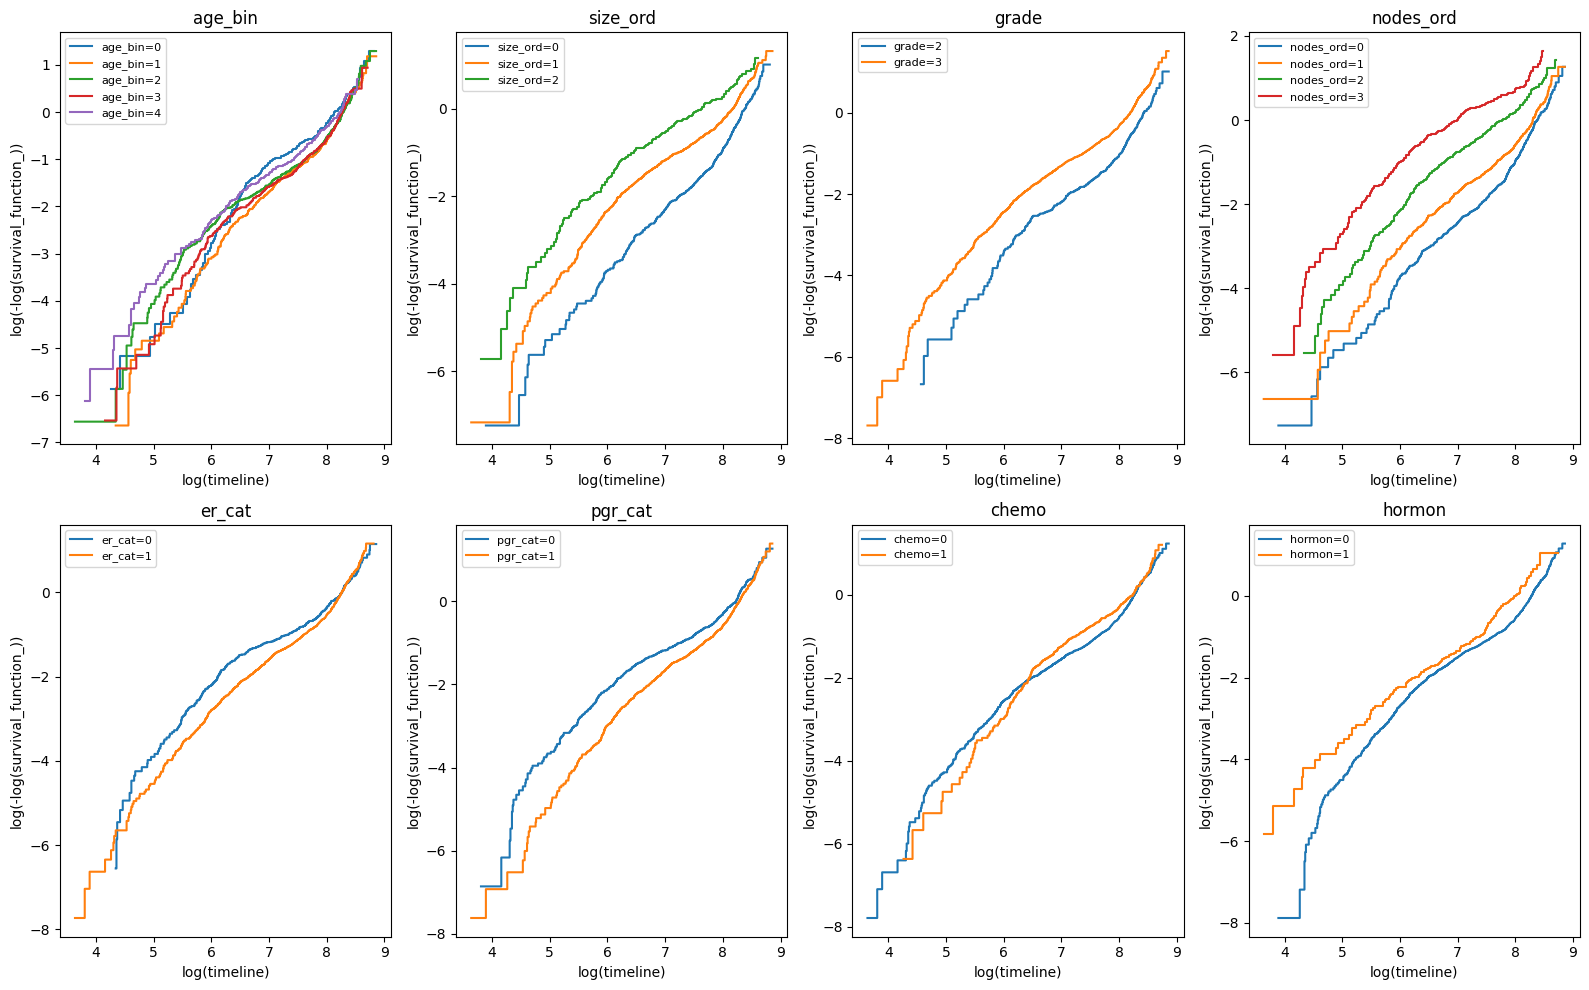

In [ ]:
from lifelines.plotting import loglogs_plot

# Create a grid of subplots for all features
features_to_plot = ['age_bin', 'size_ord', 'grade', 'nodes_ord', 'er_cat', 'pgr_cat', 'chemo', 'hormon']
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    feature_values = np.sort(df_clean[feature].unique())
    
    for value in feature_values:
        mask = df_clean[feature] == value
        kmf.fit(
            df_clean.loc[mask, 'rtime'],
            event_observed=df_clean.loc[mask, 'recur'],
            label=f'{feature}={value}'
        )
        loglogs_plot(kmf, ax=axes[idx])
    
    axes[idx].set_title(f'{feature}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

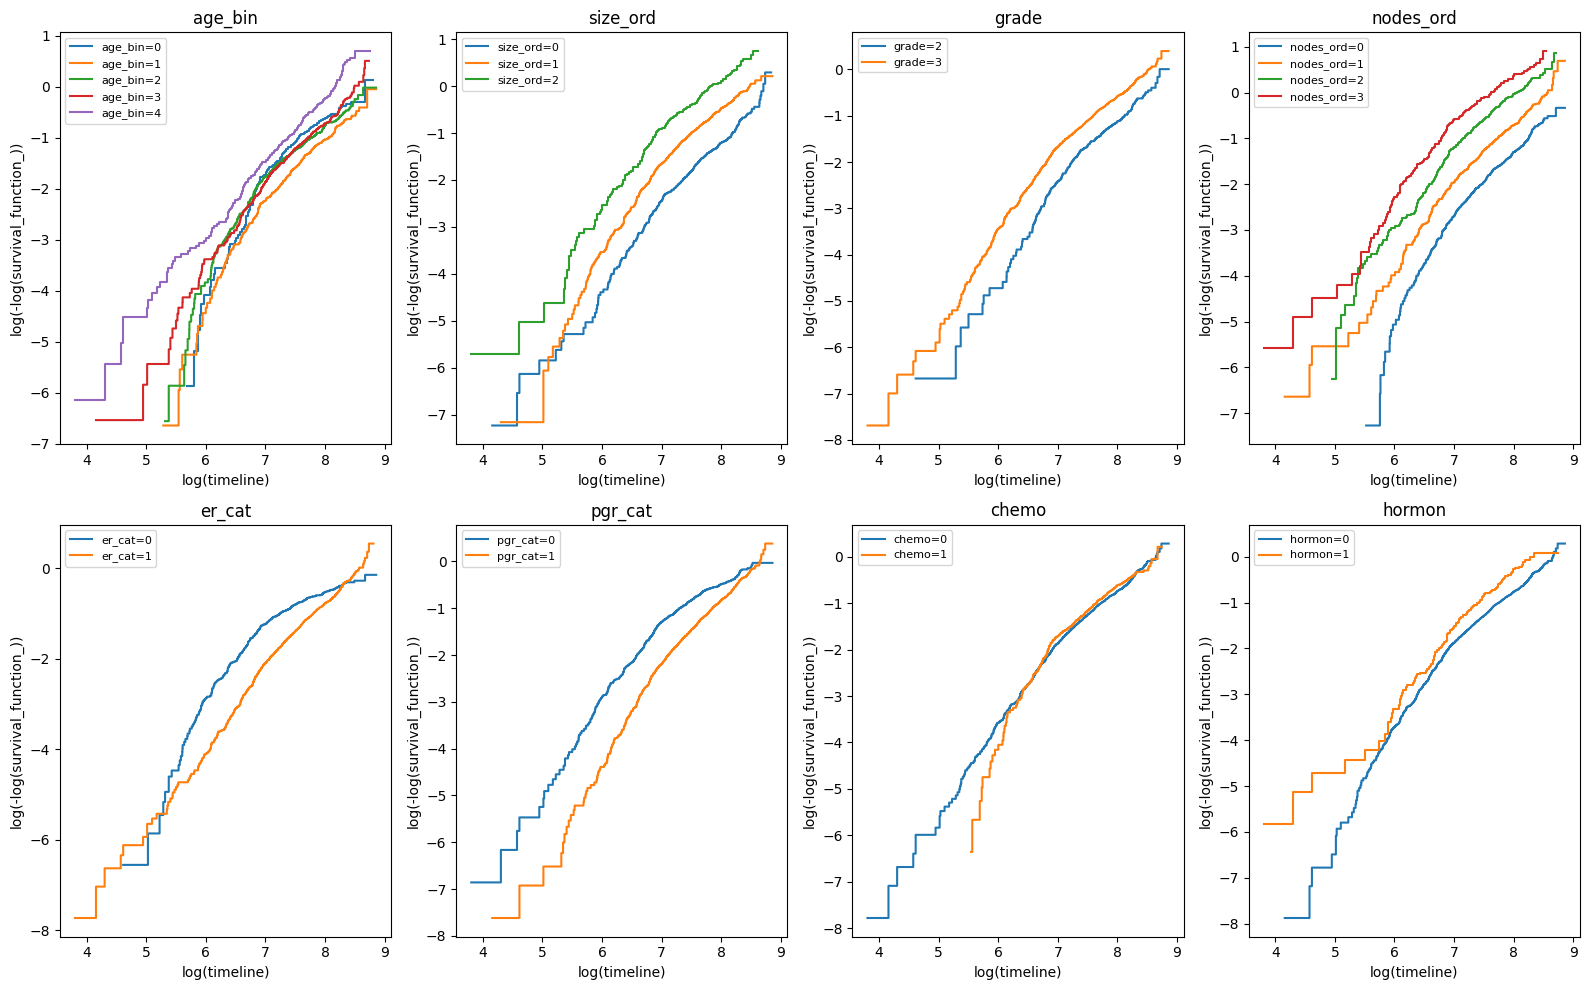

: 

In [ ]:
features_to_plot = ['age_bin', 'size_ord', 'grade', 'nodes_ord', 'er_cat', 'pgr_cat', 'chemo', 'hormon']
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    feature_values = np.sort(df_clean[feature].unique())
    
    for value in feature_values:
        mask = df_clean[feature] == value
        kmf.fit(
            df_clean.loc[mask, 'dtime'],
            event_observed=df_clean.loc[mask, 'death'],
            label=f'{feature}={value}'
        )
        loglogs_plot(kmf, ax=axes[idx])
    
    axes[idx].set_title(f'{feature}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()